# Nonlinear MLP Stencil: Learning State-Dependent Finite Differences

This notebook extends the linear stencil training from `inclass.ipynb` to a **nonlinear** setting.

**Key idea:** Instead of fixed stencil coefficients, we use an MLP that outputs stencil coefficients
as a function of the local solution state:

$$L[u]_i = \sum_{j \sim i} A_{ij}(\mathbf{u}_{\text{stencil}}) \, u_j$$

where $A_{ij}$ is an MLP mapping the local stencil values to a scalar weight.

**Design choices:**
- The stencil is a **nonlinear perturbation** of a centered-difference Laplacian.
  At initialization the MLP's final layer is zero, so $L[u] = D_{xx} u$ exactly.
- Time integration is **implicit Euler** (unconditionally stable), requiring a
  Newton solve at each time step.
- The Newton Jacobian is assembled in **O(N)** by using `jacrev` on the *local*
  stencil function and scattering into a sparse/banded matrix.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.func import jacrev, vmap, functional_call

## 1. Define the MLP that outputs stencil perturbations

The MLP takes a 3-element local stencil window $[u_{i-1}, u_i, u_{i+1}]$ and
outputs 3 perturbation weights $[\delta a_{-1}, \delta a_0, \delta a_1]$.

The effective stencil at node $i$ is then:
$$a_k^{(i)} = \underbrace{c_k}_{\text{centered diff}} + \underbrace{\delta a_k(\mathbf{u}_{\text{stencil}})}_{\text{MLP perturbation}}$$

Because the final linear layer is initialised to **zero**, the MLP perturbation
vanishes at the start of training, guaranteeing that the initial operator is
just the standard Laplacian and the Newton solve is well-conditioned.

In [2]:
class StencilMLP(nn.Module):
    """MLP that maps a local stencil window to perturbation coefficients.
    
    Input:  (stencil_width,) tensor  — local solution values [u_{i-1}, u_i, u_{i+1}]
    Output: (stencil_width,) tensor  — perturbation weights  [da_{-1}, da_0, da_{+1}]
    """
    def __init__(self, stencil_width=3, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(stencil_width, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, stencil_width),  # final layer
        )
        # Zero-initialise final layer so perturbation is zero at start
        with torch.no_grad():
            self.net[-1].weight.zero_()
            self.net[-1].bias.zero_()

    def forward(self, u_local):
        """u_local: (..., stencil_width)"""
        return self.net(u_local)

## 2. Build the nonlinear residual (element-wise, for vmap / jacrev)

We define a **single-node** residual function so that we can:
1. `vmap` it over all nodes to evaluate $F(u)$ in parallel, and
2. `jacrev` each local residual w.r.t. the 3-element local window, then
   scatter the $3\times 3$ local Jacobians into a global banded matrix in $O(N)$.

In [3]:
def extract_stencil_windows(u, stencil_radius=1):
    """Extract all local stencil windows from u with periodic BCs.
    
    Returns: (N, 2*stencil_radius+1) tensor of local windows.
    """
    N = u.shape[0]
    width = 2 * stencil_radius + 1
    # Pad periodically
    u_padded = torch.cat([u[-stencil_radius:], u, u[:stencil_radius]])
    # Unfold into windows
    windows = u_padded.unfold(0, width, 1)  # (N, width)
    return windows


def apply_nonlinear_stencil(u, mlp_params, mlp_buffers, mlp_forward, base_coeffs):
    """Apply the nonlinear stencil to the full solution vector u.
    
    L[u]_i = sum_k (base_coeffs[k] + delta_a_k(window_i)) * window_i[k]
    
    Returns: (N,) tensor.
    """
    windows = extract_stencil_windows(u)  # (N, 3)
    # Get MLP perturbations for every node at once
    delta_a = mlp_forward(mlp_params, mlp_buffers, windows)  # (N, 3)
    # Effective coefficients per node
    a_eff = base_coeffs.unsqueeze(0) + delta_a  # (N, 3)
    # Dot each row of a_eff with the corresponding window
    Lu = (a_eff * windows).sum(dim=1)  # (N,)
    return Lu

## 3. Implicit Euler residual and O(N) Jacobian assembly

The implicit Euler step solves:
$$F(u^{n+1}) = u^{n+1} - u^n - \Delta t \, L[u^{n+1}] = 0$$

We need the Jacobian $J = \partial F / \partial u^{n+1}$ for Newton.

**O(N) strategy:** Each row $i$ of the residual depends only on nodes
$\{i-1, i, i+1\}$.  We compute the $3 \times 3$ local Jacobian
$\partial F_i / \partial (u_{i-1}, u_i, u_{i+1})$ via `jacrev` of a
scalar-in/scalar-out local function, then scatter into a banded matrix.

In [4]:
def implicit_euler_residual(u_new, u_old, dt, mlp_params, mlp_buffers,
                            mlp_forward, base_coeffs):
    """F(u_new) = u_new - u_old - dt * L[u_new]."""
    Lu = apply_nonlinear_stencil(u_new, mlp_params, mlp_buffers,
                                 mlp_forward, base_coeffs)
    return u_new - u_old - dt * Lu


def local_residual_i(u_local_3, i, u_full, u_old_i, dt,
                     mlp_params, mlp_buffers, mlp_forward, base_coeffs):
    """Residual at a single node i as a function of the 3-element local window.
    
    This is the function we differentiate with jacrev to get the 3x1 local Jacobian row.
    """
    # MLP perturbation for this window
    delta_a = mlp_forward(mlp_params, mlp_buffers, u_local_3.unsqueeze(0)).squeeze(0)  # (3,)
    a_eff = base_coeffs + delta_a  # (3,)
    Lu_i = (a_eff * u_local_3).sum()
    return u_local_3[1] - u_old_i - dt * Lu_i  # u_local_3[1] is u_new[i]


def assemble_jacobian_banded(u_new, u_old, dt, mlp_params, mlp_buffers,
                             mlp_forward, base_coeffs):
    """Assemble the full Jacobian as a dense matrix using O(N) local jacrev calls.
    
    Each row i has at most 3 nonzero entries (columns i-1, i, i+1 mod N).
    We compute all local Jacobians with vmap+jacrev for efficiency.
    """
    N = u_new.shape[0]
    windows = extract_stencil_windows(u_new)  # (N, 3)

    # Define a function from local window -> scalar residual for one node
    def local_res_fn(u_local_3, u_old_i):
        delta_a = mlp_forward(mlp_params, mlp_buffers,
                              u_local_3.unsqueeze(0)).squeeze(0)
        a_eff = base_coeffs + delta_a
        Lu_i = (a_eff * u_local_3).sum()
        return u_local_3[1] - u_old_i - dt * Lu_i

    # jacrev of local_res_fn w.r.t. first arg (the 3-element window)
    local_jac_fn = jacrev(local_res_fn, argnums=0)  # returns (3,) per call

    # vmap over all N windows simultaneously
    all_local_jacs = vmap(local_jac_fn)(windows, u_old)  # (N, 3)

    # Scatter into dense (N, N) matrix
    J = torch.zeros(N, N, dtype=u_new.dtype, device=u_new.device)
    idx = torch.arange(N, device=u_new.device)
    for k in range(3):  # k=0 -> col i-1, k=1 -> col i, k=2 -> col i+1
        col = (idx + (k - 1)) % N
        J[idx, col] = all_local_jacs[:, k]

    return J

## 4. Newton solver with Armijo backtracking

In [21]:
def newton_solve(u_init, u_old, dt, mlp_params, mlp_buffers, mlp_forward,
                 base_coeffs, tol=1e-10, max_iter=20, verbose=False):
    """Solve F(u) = u - u_old - dt*L[u] = 0 via Newton + Armijo backtracking.
    
    All Newton iterations are detached. A single differentiable correction step
    is applied at the end (implicit function theorem) so that gradients flow
    through mlp_params even when Newton converges quickly.
    
    Returns the converged u^{n+1} with grad_fn attached.
    """
    u = u_init.detach().clone()

    for k in range(max_iter):
        with torch.no_grad():
            F_val = implicit_euler_residual(u, u_old, dt, mlp_params, mlp_buffers,
                                            mlp_forward, base_coeffs)
            res_norm = F_val.norm().item()
            if verbose:
                print(f"  Newton iter {k}: ||F|| = {res_norm:.3e}")
            if res_norm < tol:
                break

        # jacrev needs autograd enabled — use enable_grad() to override outer no_grad()
        with torch.enable_grad():
            J = assemble_jacobian_banded(u, u_old, dt, mlp_params, mlp_buffers,
                                         mlp_forward, base_coeffs)
        with torch.no_grad():
            delta_u = torch.linalg.solve(J.detach(), -F_val)

            # Armijo backtracking
            alpha = 1.0
            c1 = 1e-4
            tau = 0.5
            phi_current = 0.5 * F_val.dot(F_val)
            directional_deriv = -F_val.dot(F_val)

            for _ in range(20):
                u_trial = u + alpha * delta_u
                F_trial = implicit_euler_residual(u_trial, u_old, dt, mlp_params,
                                                  mlp_buffers, mlp_forward, base_coeffs)
                phi_trial = 0.5 * F_trial.dot(F_trial)
                if phi_trial <= phi_current + c1 * alpha * directional_deriv:
                    break
                alpha *= tau

            u = u + alpha * delta_u

    # --- Differentiable correction (implicit function theorem) ---
    # u is now converged but detached. One final Newton-like step *with* gradients
    # connects the output to mlp_params. Since F(u*) ≈ 0, the correction is tiny
    # but carries the correct ∂u*/∂θ = -J⁻¹ ∂F/∂θ.
    u_detached = u.detach()
    F_val = implicit_euler_residual(u_detached, u_old, dt, mlp_params, mlp_buffers,
                                    mlp_forward, base_coeffs)
    J = assemble_jacobian_banded(u_detached, u_old, dt, mlp_params, mlp_buffers,
                                 mlp_forward, base_coeffs)
    delta_u = torch.linalg.solve(J, -F_val)
    u_out = u_detached + delta_u

    return u_out

## 5. Training setup

We generate training data from the exact heat equation solution
$u^{\text{ex}}(x,t) = e^{-4\pi^2 t} \sin(2\pi x)$
and train the MLP so the nonlinear stencil reproduces it under implicit Euler.

In [22]:
# --------------- Problem parameters ---------------
N = 50        # spatial grid points
M = 5         # time steps to unroll during training
device = 'cpu'

dx = 1.0 / N
dt = 0.01
x_grid = torch.linspace(0, 1.0 - dx, N, device=device)
t_grid = torch.linspace(0, dt * M, M + 1, device=device)

# True solution snapshots
u_true_snapshots = torch.stack([
    torch.exp(-4 * torch.pi**2 * t) * torch.sin(2 * torch.pi * x_grid)
    for t in t_grid
])  # (M+1, N)

# Base (linear) centered-difference stencil coefficients: [1, -2, 1] / dx^2
base_coeffs = torch.tensor([1.0, -2.0, 1.0], device=device) / (dx ** 2)

print(f"Grid: N={N}, dx={dx:.4f}")
print(f"Time: M={M} steps, dt={dt}")
print(f"Base stencil: {base_coeffs.tolist()}")

Grid: N=50, dx=0.0200
Time: M=5 steps, dt=0.01
Base stencil: [2500.0, -5000.0, 2500.0]


In [23]:
# --------------- Model ---------------
mlp = StencilMLP(stencil_width=3, hidden=16).to(device)

# Use torch.func.functional_call to make the MLP usable inside vmap/jacrev.
# We extract (params, buffers) and define a pure-function forward pass.
mlp_params = dict(mlp.named_parameters())
mlp_buffers = dict(mlp.named_buffers())

def mlp_forward(params, buffers, x):
    """Pure-function forward pass for the MLP (compatible with vmap/jacrev)."""
    return functional_call(mlp, (params, buffers), (x,))

# Verify: at init the perturbation should be ~zero
test_window = torch.randn(1, 3)
print("MLP output at init (should be ~0):", mlp_forward(mlp_params, mlp_buffers, test_window))

MLP output at init (should be ~0): tensor([[0., 0., 0.]], grad_fn=<AddmmBackward0>)


## 6. Verify Newton solver works at initialisation

Since the MLP perturbation is zero, this should behave like implicit Euler
with the standard Laplacian and converge in ~1 Newton iteration.

In [24]:
u0 = u_true_snapshots[0].clone()
u1_newton = newton_solve(u0, u0, dt, mlp_params, mlp_buffers, mlp_forward,
                         base_coeffs, tol=1e-10, max_iter=10, verbose=True)

# Compare to direct linear solve (since perturbation is zero, should match)
D_lin = torch.zeros(N, N)
for i in range(N):
    D_lin[i, (i-1) % N] = base_coeffs[0]
    D_lin[i, i]          = base_coeffs[1]
    D_lin[i, (i+1) % N] = base_coeffs[2]
A_lin = torch.eye(N) - dt * D_lin
u1_linear = torch.linalg.solve(A_lin, u0)

print(f"\n||Newton - LinearSolve|| = {(u1_newton - u1_linear).norm():.3e}  (should be ~0)")

  Newton iter 0: ||F|| = 1.971e+00
  Newton iter 1: ||F|| = 7.136e-06
  Newton iter 2: ||F|| = 7.136e-06
  Newton iter 3: ||F|| = 7.136e-06
  Newton iter 4: ||F|| = 7.136e-06
  Newton iter 5: ||F|| = 7.136e-06
  Newton iter 6: ||F|| = 7.136e-06
  Newton iter 7: ||F|| = 7.136e-06
  Newton iter 8: ||F|| = 7.136e-06
  Newton iter 9: ||F|| = 7.136e-06

||Newton - LinearSolve|| = 1.442e-06  (should be ~0)


## 7. Training loop

In [26]:
# --------------- Optimizer ---------------
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
num_epochs = 500

print(f"{'Epoch':<8} {'Loss':<15}")
print("-" * 30)

loss_history = []

# Cache converged solutions across epochs for warm-starting Newton
# Initialize with copies of the initial condition
cached_solutions = [u_true_snapshots[0].clone().detach() for _ in range(M + 1)]

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Re-extract params each iteration (they are updated by optimizer)
    mlp_params = dict(mlp.named_parameters())
    mlp_buffers = dict(mlp.named_buffers())

    # Roll out M implicit-Euler steps with Newton solve
    total_loss = torch.tensor(0.0, device=device)
    u_current = u_true_snapshots[0].clone()

    for step in range(M):
        # Use cached solution from last epoch as Newton initial guess
        u_guess = cached_solutions[step + 1]

        # Newton solve for u^{n+1}
        u_next = newton_solve(u_guess, u_current, dt,
                              mlp_params, mlp_buffers, mlp_forward,
                              base_coeffs, tol=1e-5, max_iter=10)

        # Cache converged solution for next epoch's warm start
        cached_solutions[step + 1] = u_next.detach().clone()

        # Loss: compare to true solution
        step_loss = torch.mean((u_next - u_true_snapshots[step + 1]) ** 2)
        total_loss = total_loss + step_loss
        u_current = u_next

    loss = total_loss / M
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if epoch % 25 == 0 or epoch == num_epochs - 1:
        print(f"{epoch:<8} {loss.item():<15.3e}")

print("\nTraining complete.")

Epoch    Loss           
------------------------------
0        5.016e-10      
25       1.190e-09      
50       4.703e-10      
75       4.549e-10      
100      4.345e-10      
125      4.195e-10      
150      3.999e-10      
175      3.876e-10      
200      3.739e-10      
225      3.572e-10      
250      3.444e-10      
275      3.309e-10      
300      3.182e-10      
325      3.045e-10      
350      2.937e-10      
375      2.832e-10      
400      2.717e-10      
425      2.642e-10      
450      2.538e-10      
475      2.412e-10      
499      2.351e-10      

Training complete.


## 8. Visualisation

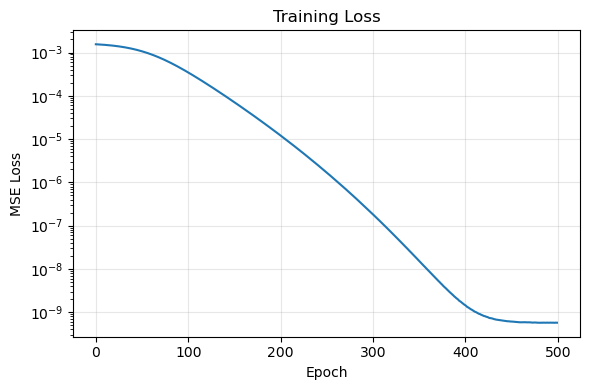

In [17]:
# --- Loss curve ---
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.semilogy(loss_history)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('Training Loss')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

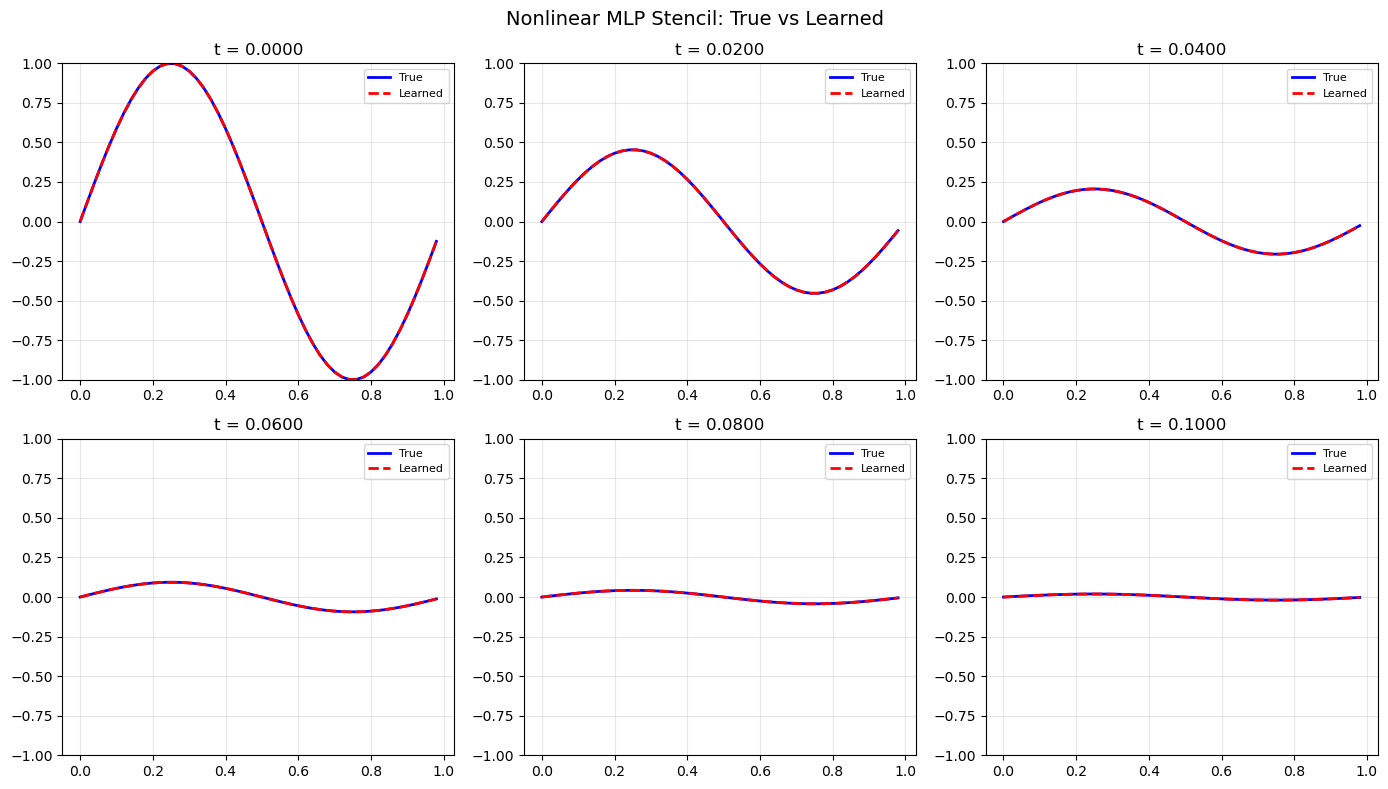

In [18]:
# --- Roll out learned model and compare to truth ---
mlp.eval()
mlp_params_eval = dict(mlp.named_parameters())
mlp_buffers_eval = dict(mlp.named_buffers())

M_test = 10  # roll out further than training
t_test = torch.linspace(0, dt * M_test, M_test + 1, device=device)
u_true_test = torch.stack([
    torch.exp(-4 * torch.pi**2 * t) * torch.sin(2 * torch.pi * x_grid)
    for t in t_test
])

u_learned = torch.zeros(M_test + 1, N, device=device)
u_learned[0] = u_true_test[0].clone()

with torch.no_grad():
    for step in range(M_test):
        u_learned[step + 1] = newton_solve(
            u_learned[step], u_learned[step], dt,
            mlp_params_eval, mlp_buffers_eval, mlp_forward,
            base_coeffs, tol=1e-10, max_iter=20
        )

# Plot snapshots
x_np = x_grid.numpy()
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Nonlinear MLP Stencil: True vs Learned', fontsize=14)
snap_idx = [0, 2, 4, 6, 8, M_test]
for idx, si in enumerate(snap_idx):
    ax = axes[idx // 3, idx % 3]
    ax.plot(x_np, u_true_test[si].numpy(), 'b-', lw=2, label='True')
    ax.plot(x_np, u_learned[si].numpy(), 'r--', lw=2, label='Learned')
    ax.set_title(f't = {t_test[si]:.4f}')
    ax.set_ylim([-1, 1])
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Inspect the learned stencil

Evaluate the effective stencil coefficients at each node for the initial condition
to see how the MLP modifies the base Laplacian.

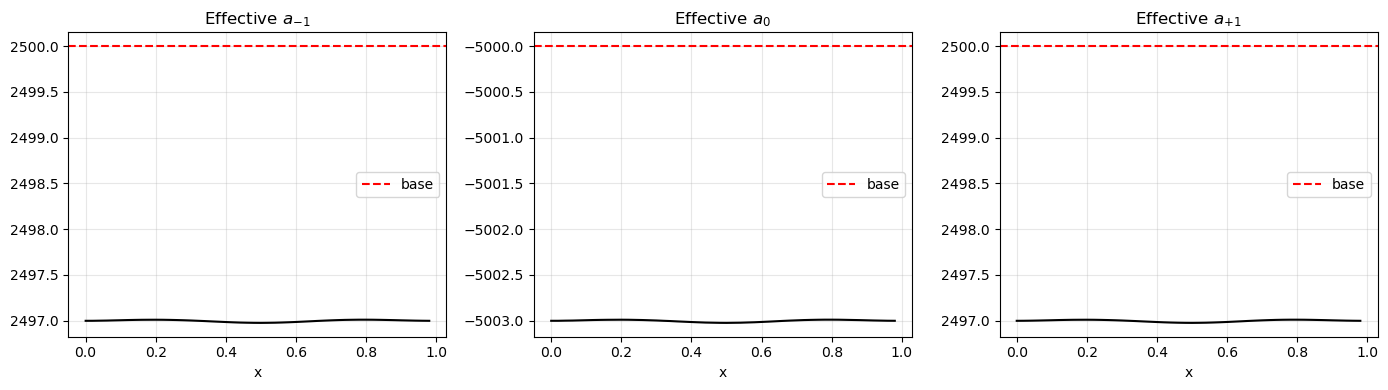

In [19]:
with torch.no_grad():
    windows_ic = extract_stencil_windows(u_true_test[0])
    delta_a_ic = mlp_forward(mlp_params_eval, mlp_buffers_eval, windows_ic)
    a_eff_ic = base_coeffs.unsqueeze(0) + delta_a_ic

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
labels = ['$a_{-1}$', '$a_0$', '$a_{+1}$']
for k in range(3):
    axes[k].plot(x_np, a_eff_ic[:, k].numpy(), 'k-', lw=1.5)
    axes[k].axhline(base_coeffs[k].item(), color='r', ls='--', label='base')
    axes[k].set_title(f'Effective {labels[k]}')
    axes[k].set_xlabel('x')
    axes[k].legend()
    axes[k].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()